**Deep Kalman Filter example with a 3-dof mass-spring-damper model: linear model, only 1-dof known and no model error estimation, measured variables: position of the first mass, actuation force on the second mass. No model closure, only parameter estimation.**

...

In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import scipy.io as sio
import pickle
import sys

DKFDirectory = '..'
sys.path.append(DKFDirectory)
import CreateTrainingSet_3_masses_4DKF

from DeepKalmanFilter.main import main
from DeepKalmanFilter.ConstructLaplacianMatrices import *
from DeepKalmanFilter.ConstructSGMatrices import *
from DeepKalmanFilter.ConstructTVMatrices import *
from DeepKalmanFilter.Utility import *
WorkingDirectory = './'

M1 =  27.0
M2 =  120.0
M3 =  11246.0
K1 =  180000000.0
K2 =  60000000.0
K3 =  120000000.0
C1 =  50000.0
C2 =  46000.0
C3 =  240000.0
coordinate di partenza: y1=0.06, y2=0.06, y3=0.05


Observability Grammian =  [[4.92674628e-06 3.64890113e-08 2.70248936e-12 4.94499214e-03
  1.82445057e-05 1.35124468e-09]
 [3.64890113e-08 2.70248937e-10 2.00154746e-14 3.66241458e-05
  1.35124469e-07 1.00077373e-11]
 [2.70248936e-12 2.00154746e-14 1.48240813e-18 2.71249784e-09
  1.00077373e-11 7.41204064e-16]
 [4.94499214e-03 3.66241458e-05 2.71249784e-09 5.96330557e+00
  1.83120729e-02 1.35624892e-06]
 [1.82445057e-05 1.35124469e-07 1.00077373e-11 1.83120729e-02
  6.75622344e-05 5.00386864e-09]
 [1.35124468e-09 1.00077373e-11 7.41204064e-16 1.35624892e-06
  5.00386864e-09 3.70602032e-13]]


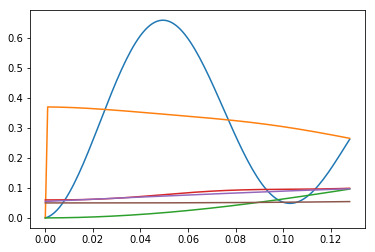

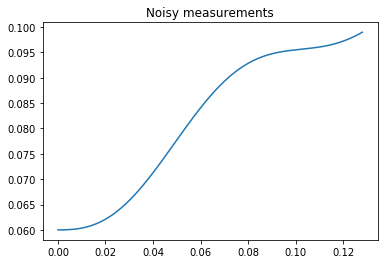

MassMat =  [[  2.7   0.    0.    0.    0.    0. ]
 [  0.  270.    0.    0.    0.    0. ]
 [  0.    0.  270.    0.    0.    0. ]
 [  0.    0.    0.    1.    0.    0. ]
 [  0.    0.    0.    0.    1.    0. ]
 [  0.    0.    0.    0.    0.    1. ]]
MassMatm =  [[2.7 0. ]
 [0.  1. ]]
LinMat =  [[-1.e+01  1.e+01  0.e+00 -1.e+04  1.e+04  0.e+00]
 [ 1.e+01 -2.e+01  1.e+01  1.e+04 -2.e+04  1.e+04]
 [ 0.e+00  1.e+01 -2.e+01  0.e+00  1.e+04 -2.e+04]
 [ 1.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00]
 [ 0.e+00  1.e+00  0.e+00  0.e+00  0.e+00  0.e+00]
 [ 0.e+00  0.e+00  1.e+00  0.e+00  0.e+00  0.e+00]]
LinMatm =  [[-1.e+01 -1.e+04]
 [ 1.e+00  0.e+00]]


In [2]:
# dataset creation:
CreateTrainingSet_3_masses_4DKF.create(Experiment='3MKC2',M1=2.7,K1=1e4,C1=1e1,epsilon=1.e2,load_0=1.e5,config_attuatori=2,config_sensori=4)

In [5]:
TrainingBatchNum = 200 #300 #150 #1000
TrainingBatchSize = 1

# DKF parameters setting:
NetParameters = {}
### General parameters:
NetParameters['Experiment'] = sio.loadmat('Experiment.mat',squeeze_me = True)['Experiment']
NetParameters['Layers'] = sio.loadmat(f'LayersExp{NetParameters["Experiment"]}.mat',squeeze_me = True)['Layers']
NetParameters['Model'] = loadPickle(f'ModelExp{NetParameters["Experiment"]}.mat')
NetParameters['C'] = sio.loadmat(f'CExp{NetParameters["Experiment"]}.mat',squeeze_me = False)['C']
NetParameters['StateDimension'] = NetParameters['C'].shape[1]
NetParameters['ObservationDimension'] = NetParameters['C'].shape[0]
NetParameters['WeightMats'] = 'Input'  #Supported values: Input, Identity  
NetParameters['HiddenDynamicsNumber'] = 1
NetParameters['HiddenDynamicsDimension'] = [sio.loadmat(f'HiddenDynDimExp{NetParameters["Experiment"]}.mat',squeeze_me = True)['HiddenDynDim']]*NetParameters['HiddenDynamicsNumber']
NetParameters['ActivateModelDiscovery'] = 'No' #'No','Yes'
### Learning parameters:
NetParameters['SharedWeights'] = 'No' #'No','Yes'
NetParameters['BackPropagation'] = 'Truncated' #'Complete','Truncated'                                           #Supported values: Complete, Truncated  
NetParameters['ProjectDynamics'] = 'No' #'No','Yes'
NetParameters['Jacobians'] = 'Approximated' #'Approximated', 'Algebraic'  
NetParameters['FiniteDifferences'] = 'Central' #'Supported values: 'Forward', 'Backward', 'Central'  
NetParameters['FiniteDifferencesSkip'] = 1.e-2 
NetParameters['GainLearningRate'] = (1e-2) / TrainingBatchSize
NetParameters['GainLearningRateReduction'] = 0.8 #1
NetParameters['GainLearningRateIncrease'] = 1e2
NetParameters['DynamicsLearningRate'] = (1.e0) / TrainingBatchSize
NetParameters['DynamicsLearningRateReduction'] = 0.2
### Loss function parameters:
Pen1Val = 1e0
Pen2Val = np.ones(NetParameters['Layers']) * 1e0
NormPen = max(Pen1Val, Pen2Val.max())
NetParameters['Penalty0'] = 1.e6
NetParameters['Penalty1'] = np.ones(NetParameters['Layers']) * Pen1Val / NormPen
NetParameters['Penalty2'] = Pen2Val / NormPen
NetParameters['Penalty3'] = 1.e0 / (NetParameters['StateDimension'] * NetParameters['ObservationDimension'])
NetParameters['Penalty4'] = 0.01 #0.2 # soft-thresholding
#NetParameters['WinLen'] = 31
#NetParameters['StencilA0'], NetParameters['StencilA1'] = ConstructSGMatrices(NetParameters['WinLen'])
NetParameters['L'], NetParameters['LtL'] = ConstructLaplacianMatrices( NetParameters['Layers'], NetParameters['Model']['SamplingTimes'] )
### Adam (learning optimizer) parameters:
NetParameters['Optimizer'] = 'Adam'
NetParameters['BetaMoment1'] = 0.9
NetParameters['BetaMoment2'] = 0.999
NetParameters['Initialization'] = 'Deterministic'   #'Random', 'Deterministic', 'DeterministcComplete'  
NetParameters['InitializationMean'] = 0
NetParameters['InitializationSigma'] = 0.0001
NetParameters['AdamEpsilon'] = 1e-16
### Learning stop condition parameters:
NetParameters['TrainingConditionStop'] = 'Residues' #'Whiteness', 'Residues'  
NetParameters['ResidueDecreaseThreshold'] = 1e-3
NetParameters['ActivateWhitenessMask'] = 'Yes'
NetParameters['WhitenessLagCounter'] = 1
NetParameters['WhitenessIterationCheck'] = 20
NetParameters['WhitenessUpdateCheck'] = 8
NetParameters['WhitenessDecreaseThreshold'] = -1e-3
### Model discovery parameters:
NetParameters['DictionaryBlocks'] = ['Constant', 'Linear', 'Quadratic', 'Cubic']
NetParameters['AllowedDictionaryBlocks'] = {
    'Constant': 1,
    'Linear': NetParameters['StateDimension'],
    'Quadratic': NetParameters['StateDimension'] * (NetParameters['StateDimension'] + 1) // 2,
    'Cubic': NetParameters['StateDimension'] * (NetParameters['StateDimension'] + 1) * (NetParameters['StateDimension'] + 2) // 6
}
NetParameters['DictionaryDimension'] = sum(NetParameters['AllowedDictionaryBlocks'][block] for block in NetParameters['DictionaryBlocks'])
NetParameters['ModelDiscoveryForceCheck'] = 1000
NetParameters['ModelDiscoveryUpdateBoth'] = 'Yes'
NetParameters['ModelDiscoveryMethod'] = 'OMP'                                            #Supported values: OMP, LH  
NetParameters['ModelDiscoverySmoothing'] = 'SGMixed2'                                    #Supported values: TV, TVMixed, SG, SGMixed1, SGMixed2
NetParameters['ModelDiscoveryFirstState'] = min(0, NetParameters['Layers'] // 2)
NetParameters['A'], NetParameters['D'], NetParameters['AtA'], NetParameters['B'] = ConstructTVMatrices( NetParameters['Layers'] - NetParameters['ModelDiscoveryFirstState'], NetParameters['Model']['SamplingTimes'] )
NetParameters['WinLen'] = 31
NetParameters['StencilA0'], NetParameters['StencilA1'] = ConstructSGMatrices(NetParameters['WinLen'])
NetParameters['ModelDiscoveryRelativeThreshold'] = 0.8
NetParameters['ModelDiscoveryStblSuppCondition'] = 4
NetParameters['ModelDiscoveryStblSuppUpdates'] = 1
NetParameters['OMPSparsity'] = 1

# Save net parameters
sio.savemat('DefaultNetParameters.mat', {'NetParameters': NetParameters})


/Users/marcuzzi/opt/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/io/matlab/miobase.py:414: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  arr[empties] = ' '


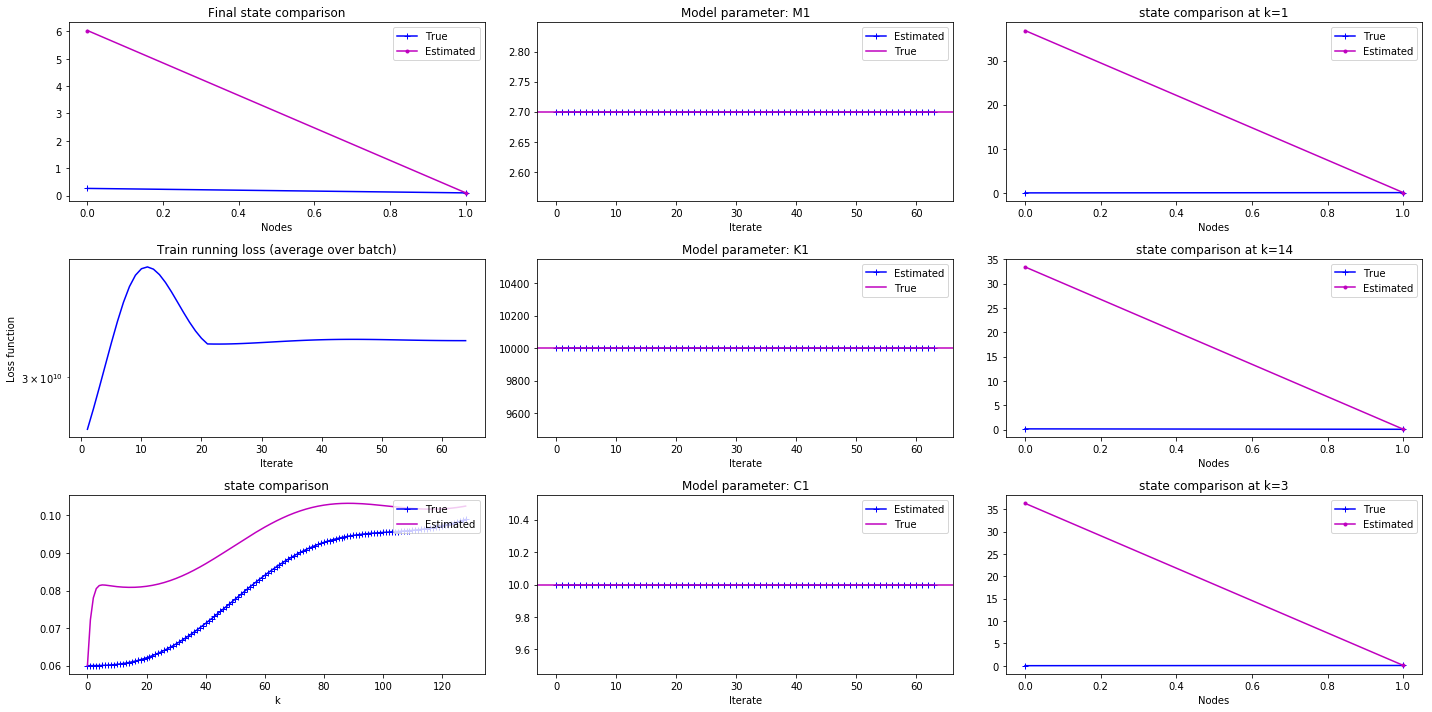

p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 

np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p) =  [0. 0. 0.]
p =  [[0.]
 [0.]
 [0.]]
np.squeeze(p

KeyboardInterrupt: 

In [6]:
main(WorkingDirectory,NetParameters,TrainingBatchSize,TrainingBatchNum)

In [ ]:
print(NetParameters['StateDimension'])

In [ ]:
v = np.array([[1,2,3],[3,4,4],[4,2,2]]); print(np.sum(v,axis=0,keepdims=True))

In [ ]:
#### Training:
#
# initialize network weights:
NetWeights = InitializeWeights(NetParameters)
# Load the training set
WorkingTrainingSetName = f'LatestTrainingSetExp{NetParameters["Experiment"]}.mat'
TrainingSet = loadPickle(WorkingTrainingSetName)
# Setup dimensions
TrainInstancesNum = np.shape(TrainingSet[0])[0]
TrainingResidues = np.zeros((TrainingBatchNum,1))
OverallStateEstimationError = np.zeros((TrainingBatchNum,1))
PeriodogramResidues = np.zeros((TrainingBatchNum, 2 * NetParameters['ObservationDimension'], TrainInstancesNum))
# Set up the figure
plt.figure(1)
plt.gcf().set_size_inches(20, 10)
# Initialize the moments
Moment1, Moment2 = InitializeGradsAndMoments(NetWeights, NetParameters)[1:]
AdamInd = 1
# Compute weight matrices
MeasurementWeightMats, PredictorWeightMats, MeasurementWeightMatsSym, PredictorWeightMatsSym = ComputeWeightMats(NetParameters)

# Cycle over batch number
for TrainingBatchInd in range(1, TrainingBatchNum+1):
    # Reset gradients for new batch but keep the moments intact
    Grads = InitializeGradsAndMoments(NetWeights, NetParameters)[0]

    # Cycle over each training instance in the batch
    for BatchInd in range(1, TrainingBatchSize+1):
        # Randomly select a training instance
        TrainInstanceInd = BatchInd-1

        # Extract instance
        Inputs = TrainingSet[0][TrainInstanceInd]
        Measurements = TrainingSet[1][TrainInstanceInd]
        FirstState = TrainingSet[2][TrainInstanceInd]
        TrajectoryTrue = TrainingSet[3][TrainInstanceInd]
        StateTrue = TrainingSet[4][TrainInstanceInd]
        Dynamic = TrainingSet[5][TrainInstanceInd]
        
        # Print progress
        #OverallProgress = f'Training batch number: {TrainingBatchInd}/{TrainingBatchNum}. \nCurrently processing batch instance: {BatchInd}/{TrainingBatchSize}. \n'
        #print(OverallProgress, end='')

        #PropagationProgress = 'Propagating instance...\n'
        #print(PropagationProgress, end='')

        # Propagate input
        States, MeasurementMinusCStates, GainMeasurementMinusCFs, MeasurementMinusCFs, FStateDynInputs = PropagateInput(Inputs, Measurements, FirstState, Dynamic, F, NetWeights, NetParameters, decode)
        #if TrainingBatchInd > 0: plt.pause(30.0)
        # Assemble gains tensor
        TensorizedGains = ConstructTensorizedGains(NetWeights, NetParameters)

        # Update training residue, cumulative periodograms residues and assemble states evolution
        ShowStates = np.zeros((NetParameters['Layers']+1, NetParameters['StateDimension']))
        ShowCorrectorResidues = np.zeros((NetParameters['Layers'], NetParameters['ObservationDimension']))
        ShowPredictorResidues = np.zeros((NetParameters['Layers'], NetParameters['ObservationDimension']))
        ShowMeasurements = np.zeros((NetParameters['Layers']+1, NetParameters['ObservationDimension']))  # TO BE REMOVED
        ShowStates[0:1,:] = FirstState.T
        ShowMeasurements[0:1,:] = Measurements[:,0:1].T

        for Layer in range(1, NetParameters['Layers'] + 1):
            TrainingResidues[TrainingBatchInd-1,0] += np.squeeze( (NetParameters['Penalty1'][Layer-1]/2)*( MeasurementMinusCStates[:,[Layer-1]].T )@MeasurementWeightMats[Layer-1]@( MeasurementMinusCStates[:,[Layer-1]] )/TrainingBatchSize + (NetParameters['Penalty2'][Layer-1]/2)*( GainMeasurementMinusCFs[:,[Layer-1]].T )@PredictorWeightMats[Layer-1]@( GainMeasurementMinusCFs[:,[Layer-1]] )/TrainingBatchSize )
            ShowStates[Layer,:] = States[:,[Layer]].T
            ShowMeasurements[Layer,:] = Measurements[:,Layer:Layer+1].T  # TO BE REMOVED
            ShowCorrectorResidues[Layer-1,:] = MeasurementMinusCStates[:,[Layer-1]].T
            ShowPredictorResidues[Layer-1,:] = GainMeasurementMinusCFs[:,[Layer-1]].T
        #endfor
        TrainingResidues[TrainingBatchInd-1] += np.squeeze( (NetParameters['Penalty0']/2)*np.linalg.norm( States[:,-1] - StateTrue )**2/TrainingBatchSize + (NetParameters['Penalty3']/2)*np.linalg.norm( np.tensordot(TensorizedGains, NetParameters['L'], axes=([2], [1])) )**2/TrainingBatchSize )
        PeriodogramResidues[TrainingBatchInd-1,:,TrainInstanceInd-1] += ComputePeriodogramResidue(MeasurementMinusCStates, MeasurementMinusCFs)
        OverallStateEstimationError[TrainingBatchInd-1] = np.linalg.norm(np.squeeze(TrainingSet[3][0][:,:]) - np.squeeze(States[:,:]),'fro')
        # Check whiteness
        #if ( (NetParameters['ActivateWhitenessMask'] == 'Yes') and (not InhibitWhitenessCheck) and (TrainingBatchInd > NetParameters['WhitenessIterationCheck'] and AdamInd > NetParameters['WhitenessUpdateCheck']) ):
        #    StopCond = (PeriodogramResidues[TrainingBatchInd-1,NetParameters['ObservationDimension']:,TrainInstanceInd-1] - PeriodogramResidues[TrainingBatchInd-2,NetParameters['ObservationDimension']:,TrainInstanceInd-1] < NetParameters['WhitenessDecreaseThreshold']).T
        ##endif

        #BackPropagationProgress = 'Back-propagating instance...\n'
        #print(BackPropagationProgress, end='')

        # Compute jacobians
        StateJacobians, DynJacobians = ComputeJacobians(F, States, None, Inputs, None, None, FStateDynInputs, NetParameters)

        # Backpropagate output
        Grads = BackPropagateOutput(StateTrue, Dynamic, States, MeasurementMinusCStates, GainMeasurementMinusCFs, MeasurementMinusCFs, FStateDynInputs, TensorizedGains, MeasurementWeightMatsSym, PredictorWeightMatsSym, Grads, StateJacobians, DynJacobians, NetWeights, NetParameters)
    #endfor

    #UpdateWeightsProgress = 'Updating weights...\n'
    #print(UpdateWeightsProgress, end='')

    # Update net weights
    #ERA COSì: NetWeights, Moment1, Moment2 = UpdateWeights(NetWeights, copy.deepcopy(Grads), Moment1, Moment2, Dynamic, AdamInd, np.ones((NetParameters['StateDimension'], 1)) - NetParameters['C'].T@( np.logical_not(np.sum(LaggedGainMask, axis=1))*1 ), NetParameters)
    NetWeights, Moment1, Moment2 = UpdateWeights(NetWeights, copy.deepcopy(Grads), Moment1, Moment2, Dynamic, AdamInd, np.ones((NetParameters['StateDimension'], 1)), NetParameters)

    AdamInd += 1

    #print('\b' * len(UpdateWeightsProgress), end='')

    # Adaptively change the learning rates
    if TrainingResidues[TrainingBatchInd-1] < NetParameters['GainLearningRate']:
        NetParameters['GainLearningRate'] *= NetParameters['GainLearningRateReduction']
    #endif
    #if ( (NetParameters['TrainingConditionStop'] == 'Residues') and InhibitWhitenessCheck and (AdamInd > NetParameters['WhitenessUpdateCheck']) and ( (TrainingResidues[TrainingBatchInd-2] - TrainingResidues[TrainingBatchInd-1] < NetParameters['ResidueDecreaseThreshold']) and (TrainingResidues[TrainingBatchInd-2] - TrainingResidues[TrainingBatchInd-1] > 0) ) ):
    #    # Early stop training condition based on residues decrease
    #    StopTraining = 1

    # Show training output
    clear_output(wait=True)
    plt.figure(1, figsize=(20, 10))
    plt.clf()

    plt.subplot(2, 3, 1)
    #plt.plot(StateTrue, 'b+-')
    #plt.plot(States[-1], 'm.-')
    #plt.title('Output state comparison')
    #plt.xlabel('Nodes')
    #plt.legend(['True','Estimated'],loc='upper right')

    plt.subplot(2, 3, 2)
    plt.plot(np.diag(NetWeights[-2]),'b-')
    plt.title('np.diag(NetWeights[-2])')
    
    ix = 2
    plt.subplot(2, 3, 3)
    plt.plot(np.squeeze(TrainingSet[3][0][:,[-1]]),'b-')
    #plt.plot(np.squeeze(Xpred_hist[[ix],:]),'c--')
    plt.plot(np.squeeze(States[:,[-1]].T),'m--')
    plt.title('state estimation at last layer')
    plt.grid()
    #plt.subplot(3, 3, 3)
    #plt.imshow(NetWeights[-1][-1], aspect='auto', cmap='viridis')
    #plt.colorbar()
    #plt.title('Reconstructed unmodeled dynamics')

    plt.subplot(2, 3, 4)
    plt.semilogy(range(1, TrainingBatchInd + 1), OverallStateEstimationError[:TrainingBatchInd],'b-')
    plt.title('Overall state estimation error at each iterate')
    plt.xlabel('Iterate')
    plt.ylabel('Overall state estimation error')

    plt.subplot(2, 3, 5)
    for ix in range(1,States.shape[1]):
        plt.semilogy(ix,np.linalg.norm(np.squeeze(TrainingSet[3][0][:,[ix]]) - np.squeeze(States[:,[ix]].T)),'b.')
    #endfor
    plt.title('Current state estimation error at each layer')
    plt.xlabel('Layer')
    plt.ylabel('state estimation error')
    #plt.gca().set_prop_cycle(color=plt.cm.hsv(np.linspace(0, 1, NetParameters['ObservationDimension']+1)))
    #plt.semilogy(range(1, TrainingBatchInd + 1), PeriodogramResidues[:TrainingBatchInd, :NetParameters['ObservationDimension'],0])
    #plt.legend([f'ObservedState:{i+1}' for i in range(NetParameters['ObservationDimension'])], loc='lower left')
    #plt.title('Running corrector residue periodogram (average over batch)')
    #plt.xlabel('Iterate')
    #plt.ylabel('Periodogram residues (states)')

    #ix = 20
    plt.subplot(2, 3, 6)
    #plt.plot(np.squeeze(TrainingSet[3][0][:,[ix]]),'b-')
    ##plt.plot(np.squeeze(Xpred_hist[[ix],:]),'c--')
    #plt.plot(np.squeeze(States[:,[ix]].T),'m--')
    #plt.title('state estimation at layer '+str(ix))
    #plt.grid()
    #plt.gca().set_prop_cycle(color=plt.cm.hsv(np.linspace(0, 1, NetParameters['ObservationDimension']+1)))
    #plt.semilogy(PeriodogramResidues[:TrainingBatchInd, NetParameters['ObservationDimension']:,0])
    #plt.legend([f'ObservedState:{i+1}' for i in range(NetParameters['ObservationDimension'])], loc='lower left')
    #plt.title('Running predictor residue periodogram (average over batch)')
    #plt.xlabel('Iterate')
    #plt.ylabel('Periodogram residues (states)')

    #plt.subplot(3, 3, 7)
    #plt.gca().set_prop_cycle(color=plt.cm.hsv(np.linspace(0, 1, 2 * NetParameters['StateDimension']+1)))
    #plt.plot(np.hstack((ShowStates @ NetParameters['C'].T, ShowMeasurements)))
    #plt.legend([f'EstimatedState:{i+1}' for i in range(NetParameters['ObservationDimension'])] * 2, loc='upper left')
    #plt.title('States estimates')
    #plt.xlabel('Nodes')

    #plt.subplot(3, 3, 8)
    #plt.gca().set_prop_cycle(color=plt.cm.hsv(np.linspace(0, 1, NetParameters['StateDimension']+1)))
    #plt.semilogy(np.abs(ShowCorrectorResidues))
    #plt.legend([f'CorrectorResidues:{i+1}' for i in range(NetParameters['ObservationDimension'])], loc='upper left')
    #plt.title('Corrector Residues')
    #plt.xlabel('Nodes')

    #plt.subplot(3, 3, 9)
    #plt.gca().set_prop_cycle(color=plt.cm.hsv(np.linspace(0, 1, NetParameters['StateDimension']+1)))
    #plt.semilogy(np.abs(ShowPredictorResidues))
    #plt.legend([f'PredictorResidues:{i+1}' for i in range(NetParameters['ObservationDimension'])], loc='upper left')
    #plt.title('Predictor Residues')
    #plt.xlabel('Nodes')

    plt.tight_layout()
    plt.draw(); plt.show()
    plt.pause(0.1)
#endfor
print('********************************************************************************')
print('Training completed.')
print('Updated weights for the net have been saved and are ready to be used.')
print('********************************************************************************\n')


In [ ]:
print(d)

In [ ]:
print(NetParameters['Penalty4'])
print(OverallStateEstimationError[-1])
print(np.linalg.norm(np.squeeze(TrainingSet[3][0][:,[-1]]) - np.squeeze(States[:,[-1]].T)))
print(len(np.where(diagC > 0.0)[0]))

In [ ]:
lambda_s = [0.0,1e-09,0.01,0.1,0.2]
n2_overall = [173,503,503,844]
n2_final = [8.1,48,48,76]
d = [51,5,5,12]

In [ ]:
np.info(np.log)

In [ ]:
v = np.array([1.0, None, 3.0])
print((v == 2).any())

In [ ]:
k=1
M = NetWeights[k-1] - L_hist[:,:,k]
[U,S,V] = np.linalg.svd(M); V = V.T
plt.figure()
plt.semilogy(np.diag(np.sort(S)[-1::-1]),'b.')
plt.show()

In [ ]:
v1 = np.array(MeasurementMinusCStates[:,k-1],dtype=np.float64)
cm1 = np.corrcoef(np.atleast_2d(V[:,-1]),v1); print("corr(e,V[:,-1]) = ",cm1[1,0])
cm2 = np.corrcoef(np.atleast_2d(V[:,-2]),v1); print("corr(e,V[:,-2]) = ",cm2[1,0])

In [ ]:
v1 = np.array([1,2,3]); print("v1.shape = ",v1.shape)
v2 = np.array([1,2,3]); print("v2.shape = ",v2.shape)
print(np.corrcoef(v1,v2))

In [ ]:
v1 = np.array(MeasurementMinusCStates[:,k-1],dtype=np.float64)
print(type(v1[0]))
print("v1.shape = ",v1.shape)
v2 = V[:,-1]
print(type(v2[0]))
print("v2.shape = ",v2.shape)
np.corrcoef(v1,v2)

In [ ]:
V[:,-1].shape

In [ ]:
help(np.corrcoef)

In [ ]:
plt.figure()
plt.plot(np.diag(NetWeights[-2]),'b-')
plt.show()

In [ ]:
res_noCtraining = TrainingResidues[:TrainingBatchInd]

In [ ]:
plt.figure()
plt.plot(res_noCtraining,'b-')
plt.plot(TrainingResidues[:TrainingBatchInd],'r-')
plt.show()